# Test repository in the building process

In [1]:
import torch
from torch import nn
import pandas as pd
from matplotlib import pyplot as plt

### 1. Preprocessing

In [2]:
# Load
from load import load_data
train_df, submission_df = load_data()

In [3]:
from preprocess import preprocess

A_tilde, standardized_train_ratings, train_users, train_items, means, stds, val_users, val_items, standardized_val_ratings, submission_users, submission_items = preprocess((train_df, submission_df))

### 2. Training

HP: L=1, K=30, INIT_EMBS_STD=0.01, LR=0.05, WEIGHT_DECAY=1e-05

In [4]:
# Model and optimizer hyperparameters
L=1
K=30
INIT_EMBS_STD=0.01
LR=0.05
WEIGHT_DECAY=1e-05
DROPOUT=0.2

# Train loop hyperparameters
EPOCHS=200
STOP_THRESHOLD=1e-06

In [5]:
from train import train_model
from models import ConcatNonLinear
from config import DEVICE

model = ConcatNonLinear(A_tilde, K, L, INIT_EMBS_STD, DROPOUT).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
loss_fn = nn.MSELoss()

In [6]:
from train import train_model
# model, optimizer, loss_fn, train_users, train_items, train_ratings, val_users, val_items, val_ratings, n_epochs, improvement_threshold) -> tuple[list, list]:
train_rmse, val_rmse = train_model(model, optimizer, loss_fn, train_users, train_items, standardized_train_ratings, val_users, val_items, standardized_val_ratings, EPOCHS, STOP_THRESHOLD, save_best_model=True)

Epoch 0 - Train loss: 1.0212 - Val loss: 1.0082
Epoch 1 - Train loss: 0.9952 - Val loss: 0.9685
Epoch 2 - Train loss: 0.9529 - Val loss: 1.0604
Epoch 3 - Train loss: 1.0371 - Val loss: 1.0264
Epoch 4 - Train loss: 1.0091 - Val loss: 0.9781
Epoch 5 - Train loss: 0.9616 - Val loss: 0.9741
Epoch 6 - Train loss: 0.9586 - Val loss: 0.9828
Epoch 7 - Train loss: 0.9672 - Val loss: 0.9809
Epoch 8 - Train loss: 0.9647 - Val loss: 0.9718
Epoch 9 - Train loss: 0.9549 - Val loss: 0.9619
Epoch 10 - Train loss: 0.9442 - Val loss: 0.9554
Epoch 11 - Train loss: 0.9367 - Val loss: 0.9546
Epoch 12 - Train loss: 0.9345 - Val loss: 0.9582
Epoch 13 - Train loss: 0.9372 - Val loss: 0.9560
Epoch 14 - Train loss: 0.9349 - Val loss: 0.9484
Epoch 15 - Train loss: 0.9283 - Val loss: 0.9486
Epoch 16 - Train loss: 0.9294 - Val loss: 0.9532
Epoch 17 - Train loss: 0.9342 - Val loss: 0.9537
Epoch 18 - Train loss: 0.9344 - Val loss: 0.9506
Epoch 19 - Train loss: 0.9304 - Val loss: 0.9485
Epoch 20 - Train loss: 0.9275 

### 3. Check training results

Min training loss: 0.7858244776725769
Min validation loss: 0.9170255661010742
Min validation loss at epoch: 69


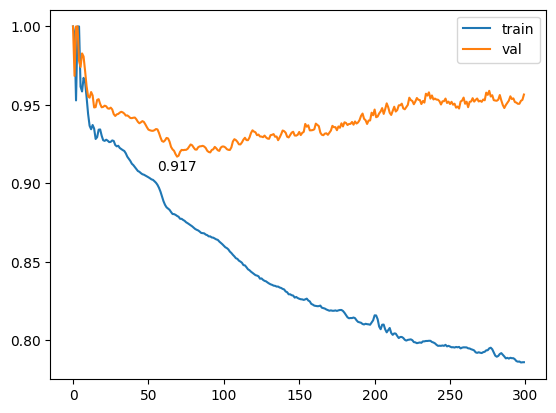

In [9]:
# Training stats

print("Min training loss:", min(train_rmse))
print("Min validation loss:", min(val_rmse))
print("Min validation loss at epoch:", val_rmse.index(min(val_rmse)))

# Replace values above 10 with 10 in the rmse lists
train_rmse_plot = [min(1, x) for x in train_rmse]
val_rmse = [min(1, x) for x in val_rmse]

# Plot train and val rmse
plt.plot(train_rmse_plot, label='train')
plt.plot(val_rmse, label='val')
# annotate min val loss
plt.annotate(round(min(val_rmse), 4), (val_rmse.index(min(val_rmse)), min(val_rmse)), textcoords="offset points", xytext=(0,-10), ha='center')


plt.legend()
plt.show()

### 4. Post-processing

In [17]:
# Read model that achieved best validation loss
model.eval()
model.load_state_dict(torch.load("../data/logs/best_val_model.pth"))

# Get predictions for submission
final_ratings = model.get_ratings(submission_users, submission_items).cpu().detach().numpy()

min: -3.6163864
max: 2.138516
mean: 0.02609509


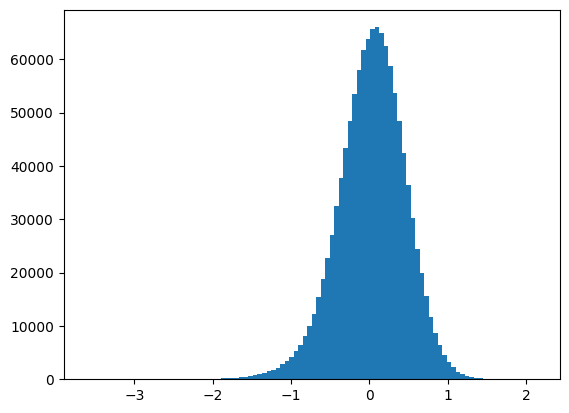

In [18]:
# Check min and max of final_ratings
print("min:", final_ratings.min())
print("max:", final_ratings.max())
print("mean:", final_ratings.mean())

# Check distribution of final_ratings
plt.hist(final_ratings.flatten(), bins=100)
plt.show()

In [19]:
import numpy as np
from config import N_u, N_v
# Reverse standardization

# Fill matrix with predictions
final_ratings_matrix = np.zeros((N_u, N_v))
final_ratings_matrix[submission_users, submission_items] = final_ratings

# Reverse standardization (no mask needed)
def reverse_standardization(submission_matrix, means, stds):
    # shape of all inputs: (n_users, n_items)
    reversed_ratings = submission_matrix * stds + means
    return reversed_ratings

final_ratings_matrix = reverse_standardization(final_ratings_matrix, means, stds)

# extract numpy array from ratings matrix
final_ratings = final_ratings_matrix[submission_users, submission_items]

In [20]:
# Clip at 1 and 5

# check min and max of final_ratings_rounded
print("min:", final_ratings.min().item())
print("max:", final_ratings.max().item())
print("mean:", final_ratings.mean().item())

# Count the number of values under 1 and over 5
count_under_1 = (final_ratings < 1).sum().item()
count_over_5 = (final_ratings > 5).sum().item()
print("count_over_5:", count_over_5)
print("count_under_1:", count_under_1)

# Clip the values to be within the range [1, 5]
final_ratings = final_ratings.clip(final_ratings, 1, 5)

min: -0.838264647635977
max: 5.9896689379528025
mean: 3.88292001354896
count_over_5: 22641
count_under_1: 233


TypeError: return arrays must be of ArrayType

min: -0.838264647635977
max: 5.9896689379528025
mean: 3.88292001354896


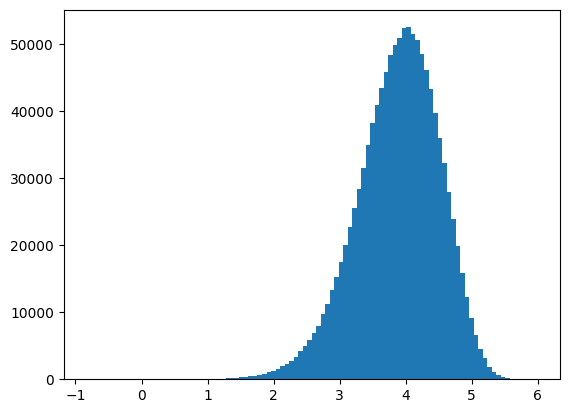

In [21]:
# check min and max of final_ratings
print("min:", final_ratings.min().item())
print("max:", final_ratings.max().item())
print("mean:", final_ratings.mean().item())

# check distribution of final_ratings
plt.hist(final_ratings.flatten(), bins=100)
plt.show()

### 5. Submission

In [23]:
# save submission
def to_submission_format(users, movies, predictions):
    return pd.DataFrame(data={'Id': ['r{}_c{}'.format(user + 1, movie + 1) for user, movie in zip(users, movies)],
                              'Prediction': predictions})

submission = to_submission_format(submission_users, submission_items, final_ratings)

submission.to_csv('../data/submission_data/submission.csv', index=False)